## Questão de negócio: encontrar casas abaixo do valor de mercado para que seja possível a realização de lucro

### Importando o dataset e trocando a coluna date para tipo datetime

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.float_format', lambda x: '%.2f' % x)

df = pd.read_csv('kc_house_data.csv')

df['date'] = pd.to_datetime(df['date'])
print(df.shape)
print(df.columns)

(21613, 21)
Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


## Limpeza de dados

### Checando se há duplicatas

In [16]:
df[df.duplicated(keep='first')]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


### Checando se há valores faltantes

In [15]:
df.isna().sum()


id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

### Procurando outliers

In [17]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00
mean,4580301520.86,540088.14,3.37,2.11,2079.90,15106.97,1.49,0.01,0.23,3.41,7.66,1788.39,291.51,1971.01,84.40,98077.94,47.56,-122.21,1986.55,12768.46
std,2876565571.31,367127.20,0.93,0.77,918.44,41420.51,0.54,0.09,0.77,0.65,1.18,828.09,442.58,29.37,401.68,53.51,0.14,0.14,685.39,27304.18
min,1000102.00,75000.00,0.00,0.00,290.00,520.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00
25%,2123049194.00,321950.00,3.00,1.75,1427.00,5040.00,1.00,0.00,0.00,3.00,7.00,1190.00,0.00,1951.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00
50%,3904930410.00,450000.00,3.00,2.25,1910.00,7618.00,1.50,0.00,0.00,3.00,7.00,1560.00,0.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7620.00
75%,7308900445.00,645000.00,4.00,2.50,2550.00,10688.00,2.00,0.00,0.00,4.00,8.00,2210.00,560.00,1997.00,0.00,98118.00,47.68,-122.12,2360.00,10083.00
max,9900000190.00,7700000.00,33.00,8.00,13540.00,1651359.00,3.50,1.00,4.00,5.00,13.00,9410.00,4820.00,2015.00,2015.00,98199.00,47.78,-121.31,6210.00,871200.00


In [39]:
df.drop(df[df['bedrooms']==33].index,inplace=True)
df.drop(df[df['bedrooms']==0].index,inplace=True)
df.drop(df[df['bathrooms']==0].index,inplace=True)
df.sort_values('bedrooms',ascending=False)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8757,1773100755,2014-08-21,520000.00,11,3.00,3000,4960,2.00,0,0,...,7,2400,600,1918,1999,98106,47.56,-122.36,1420,4960
19254,8812401450,2014-12-29,660000.00,10,3.00,2920,3745,2.00,0,0,...,7,1860,1060,1913,0,98105,47.66,-122.32,1810,3745
15161,5566100170,2014-10-29,650000.00,10,2.00,3610,11914,2.00,0,0,...,7,3010,600,1958,0,98006,47.57,-122.17,2040,11914
13314,627300145,2014-08-14,1148000.00,10,5.25,4590,10920,1.00,0,2,...,9,2500,2090,2008,0,98004,47.59,-122.11,2730,10400
4096,1997200215,2014-05-07,599999.00,9,4.50,3830,6988,2.50,0,0,...,7,2450,1380,1938,0,98103,47.69,-122.34,1460,6291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12484,1172000150,2014-08-29,238000.00,1,1.00,530,6350,1.00,0,0,...,5,530,0,1941,0,98103,47.69,-122.36,1200,6350
7017,203100460,2014-09-24,400000.00,1,1.00,530,13679,1.00,0,0,...,6,530,0,1949,0,98053,47.64,-121.95,1930,20624
13329,4356200120,2014-10-23,248000.00,1,1.00,790,12000,1.00,0,0,...,6,790,0,1918,0,98118,47.51,-122.27,1900,6000
3582,1925069006,2014-12-03,355000.00,1,0.75,530,33278,1.00,0,2,...,4,530,0,1950,0,98074,47.64,-122.08,2830,14311


## Hipótese 1: Existem casas em boas condições com valor abaixo de 50% do valor da mediana da área

### Estratégia: selecionar casas com preço abaixo da mediana de preço do respectivo zipcode (código de área) e filtrar apenas casas em boas condições.

In [40]:
median = df[['price','zipcode']].groupby('zipcode').median().reset_index()
median.rename(columns={'price':'price_median'}, inplace=True)

In [41]:
df2 = pd.merge(df, median, on=['zipcode'], how='inner')
print(df['condition'].unique())
for i in range(len(df2)):
    if (df2.loc[i,'price']< df2.loc[i,'price_median']) and (df2.loc[i,'condition']==5):
        df2.loc[i,'recommendation'] = 'buy'
    else:
        df2.loc[i,'recommendation'] = 'dont buy'


[3 5 4 1 2]


In [42]:
tobuy = df2[df2['recommendation']=='buy'][['id','zipcode','price','price_median','condition']]

### Encontrando as maiores diferenças relativas entre o preço e o preço mediano

In [43]:
tobuy['difference'] = ((tobuy['price_median']-tobuy['price'])/tobuy['price_median'])*100;
tobuy.sort_values('difference',ascending=False).head(10)

,id,zipcode,price,price_median,condition,difference
3369,5111400086,98038,110000.00,342000.00,5,67.84
10647,4337600005,98166,153000.00,390000.00,5,60.77
10065,418000310,98056,155000.00,380000.00,5,59.21
5345,1172000150,98103,238000.00,550000.00,5,56.73
10165,425200205,98056,165000.00,380000.00,5,56.58
12008,8651402750,98042,132825.00,291500.00,5,54.43
6876,3977630130,98092,146300.00,309780.00,5,52.77
18306,643300010,98006,365000.00,760184.50,5,51.99
16641,1771110090,98077,316000.00,652475.00,5,51.57
18337,2206700215,98006,375000.00,760184.50,5,50.67


## Hipótese 2: A diferença de preço mediano entre casas com 1 e 2 quartos é maior do que a diferença entre as outras quantidades de quartos

### Estratégia: tirar a média por número de quartos, depois fazer a diferença entre as médias

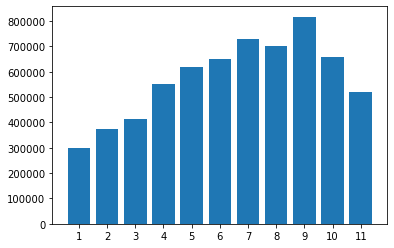

In [44]:
quartos = df[['price','bedrooms']].groupby('bedrooms').median().reset_index()



plt.bar(quartos['bedrooms'],quartos['price'])

plt.xticks(quartos['bedrooms']);


In [45]:
dif = pd.DataFrame()
for i in range(len(quartos)):
    if i == 0:
        dif.loc[i,'dif'] = 0
        dif.loc[i,'qt_quartos'] = 'De 0 para 0'
    else:
            dif.loc[i,'qt_quartos'] = 'De {} para {}'.format(quartos.loc[i-1,'bedrooms'],quartos.loc[i,'bedrooms'])
            dif.loc[i,'dif'] = quartos.loc[i,'price']-quartos.loc[i-1,'price']
dif.drop(0,inplace=True)
dif = dif.sort_values('dif',ascending=False).reset_index()
print(dif)


   index        dif     qt_quartos
0      3  136997.50    De 3 para 4
1      8  117000.00    De 8 para 9
2      6   78580.00    De 6 para 7
3      1   75000.00    De 1 para 2
4      4   70002.50    De 4 para 5
5      2   39000.00    De 2 para 3
6      5   30000.00    De 5 para 6
7      7  -28580.00    De 7 para 8
8     10 -140000.00  De 10 para 11
9      9 -157000.00   De 9 para 10


## Hipótese 3: Imóveis construídos até 1950 e que foram reformados tem preços 20% maiores do que os que não foram reformados, em média

### Estratégia: filtrar imóveis com ano construído menor que 1950, separar os que foram renovados e os que não foram e tirar as médias

<BarContainer object of 2 artists>

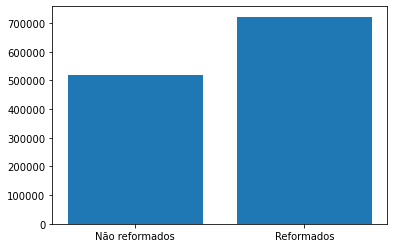

In [46]:
a_1950 = df[df['yr_built']<=1950]
aref_1950 = a_1950[a_1950['yr_renovated']!=0]['price'].mean()
nref_1950 = a_1950[a_1950['yr_renovated']==0]['price'].mean()


plt.bar(['Não reformados','Reformados'],[nref_1950,aref_1950])


## Hipótese 4: Os imóveis com vista para água se valorizam mais com o tempo

### Estratégia: fazer uma coluna apenas com o ano, agrupar com base no ano e vista pra água, plotar médias de preço com e sem vista para cada ano. 

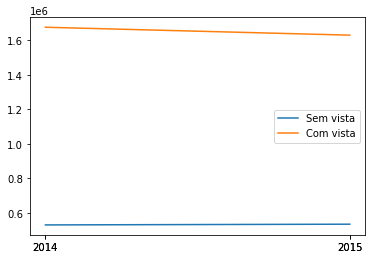

In [47]:
df['year'] = df['date'].dt.year
water = df[['price','year','waterfront']].groupby(['waterfront','year']).mean().reset_index()

plt.plot(water[water['waterfront']==0]['year'], water[water['waterfront']==0]['price'], label = "Sem vista")
plt.plot(water[water['waterfront']==1]['year'], water[water['waterfront']==1]['price'], label = "Com vista")
plt.xticks(water['year']);
plt.legend()
plt.show()

## Hipótese 5: Imóveis com porão são 20% mais caros que imóveis sem porão

### Estratégia: separar imóveis com e sem porão pela área e criar gráfico de barras

<BarContainer object of 2 artists>

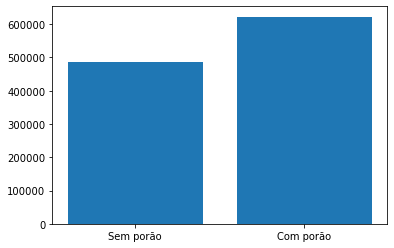

In [48]:
por = df[df['sqft_basement']>0]['price'].mean()
spor = df[df['sqft_basement']==0]['price'].mean()

plt.bar(['Sem porão','Com porão'],[spor,por])

## Hipótese 6: É possível ter diferença de preços médios de imóveis de 10% entre meses devido à sazonalidade

### Estratégia: extrair da data uma coluna de mês, criar uma nova coluna apenas com mês e ano e plotar valores médios em uma série temporal

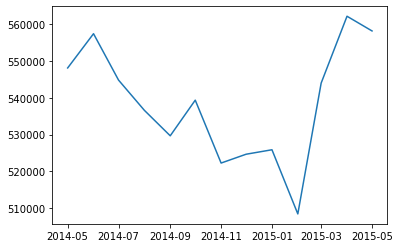

In [49]:
df['month'] = df['date'].dt.month

MoM = df[['price','month','year']].groupby(['year','month']).mean().reset_index()
MoM[['month','year']]=MoM[['month','year']].astype(str)
MoM['month/year'] = MoM['month'] + '/' + MoM['year']
MoM.drop(['year','month'],axis=1,inplace=True)
MoM['month/year'] = pd.to_datetime(MoM['month/year'],format='%m/%Y')
plt.plot(MoM['month/year'],MoM['price'])